# Background information
Solar Plan Energy's ambition is to grow to 30,000 to 75,000 energy customers over the next year. We offer customers an energy contract with hourly prices. This means that the price for electricity changes every hour. Every day at 1 p.m., customers see the prices in the Zonneplan App for the next 35 hours. They can adjust their consumption according to the prices. As an energy supplier, you are obliged to forecast and then purchase electricity for your customers as best you can.

For each quarter hour, the offtake (or feed-in) from the electricity grid must be purchased. This must be done before 10:00 D-1 for delivery day D. When the realized consumption differs from our predicted consumption we have ''imbalance''. With imbalance, we (sell) the difference between the predicted and realized volumes at the price in effect at that time (the imbalance market). The price on the imbalance market depends on the imbalance on the entire power grid and can be either positive or negative. However, on average it is unfavorable to have imbalance. This makes it important to forecast the position of your energy portfolio as well as possible.

Consumption forecasting is currently done using historical and forecast data. This is historical consumption data from the smart meter, historical and predicted solar generation data from the inverter, historical prices and historical and predicted weather data.

# Assignment
Create a consumption forecast using the dataset provided. The assignment is to forecast the expected consumption (or feed-in) in kWh per quarter hour for the period January 1 to January 7 for the sum of all active contracts in the energy portfolio.

The forecast volume per quarter hour always has only 1 position. (Offtake minus feed-in)

Return of electricity are negative values, offtake is positive.

Only consumption taken off or fed into the grid is relevant. **There can be consumption within a household that is not registered on the smart meter.** This happens when there is solar generation which is consumed directly in the house.

Not all customers have solar panels, and not everyone with solar panels purchased them from Solar Plan.

All relevant information about the data is in the ZIP file.

# What do we expect from you?
* Solution: A forecast for the period January 1 to 7 with a reading per quarter of an hour.
* Approach: Clear explanation of how you arrived at this prediction.
* Follow-up steps: How will you make this prediction even better as you work on it in the coming months?
* Reflection: What did you encounter? What went well? What could have been better?



# (English) Data explanations
**actual_values.json:**

* Contract_id: personal identification number of household
* Timestamp: quarter times in local timezone
* Pv_actual_kwh: realized generated with solar panels in kWh
* P1_actual_kwh: realized kWh on smart meter
* Pv_forecast_kwh: forecast generated with solar panels in kWh

**forecast_values.json:**

* Contract_id: personal identification number of household
* Timestamp: quarter times in local timezone
* Pv_forecast_kwh: advance expected generation with solar panels in kWh

**contracts_database_table.csv:**

* Contract_id: personal identification number of household
* Start_date: first day of customer's contract
* End_date: last day of customer's contract

**weahter_actual.json and weather_forecast.json:**

* Location_id: location of weather station
* Ghi: Global Horizontal Irradiation
* Dni: Direct Normal Irradiation
* Dhi: Diffuse Horizontal Irradiation
* Ebh: Direct (Beam) Horizontal Irradiance
* Zenith: The angle between a line perpendicular to the earth's surface and the sun (90 deg = sunrise and sunset; 0 * deg = sun directly overhead)
* Azimuth: The angle between a line pointing due north to the sun's current position in the sky. Negative to the East. Positive to the West. 0 at due North
* Cloud_opacity: The measurement of how opaque the clouds are to solar radiation in the given location.
* Air_temp: temperature in degrees celsius
Timestamp: quarter times in local timezone

**price_epex.json:**

* Price_epex: market price at which we buy and sell
* Timestamp: quarter times in local timezone

# Approach
1. Exploratory Data Analysis: 
     1. Get to know the data
     2. Are they missing values? Outliers?
     3. Can we visualize any correlations between data?
     2. Are there high level patterns which can be useful to forecast the consumption / solar power generation?
2. Solar power generation forecast
3. Power consumption forecast
4. Integration

# Libraries

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt

# Load Data

In [2]:
contracts = pd.read_csv('datafiles_assignment_data_scientist/contracten_database_table.csv', sep = ';')
values_actual = pd.read_json('datafiles_assignment_data_scientist/actual_values.json')
pv_forecast = pd.read_json('datafiles_assignment_data_scientist/forecast_values.json')
weather_actual = pd.read_json('datafiles_assignment_data_scientist/weather_actual.json')
weather_forecast = pd.read_json('datafiles_assignment_data_scientist/weather_forecast.json')
prices = pd.read_json('datafiles_assignment_data_scientist/price_epex.json')

# Exploratory Data Analysis

**Assumptions**:
* The pv_power is function of the weather and panel structure (unavailable in the data)
* The consumption is function of price, weather (e.g. the colder it is the more ones consumes energy to warm up the house), the day of the week (people tends to me more at home during week-ends than work day), hour of the day

## Contracts
**Observations:**
* The number of contracts has double in the month of December 2022

In [3]:
contracts['start_date'] = pd.to_datetime(contracts['start_date'], format = '%d-%m-%Y')
contracts['end_date'] = pd.to_datetime(contracts['end_date'], format = '%d-%m-%Y')

In [4]:
contracts.head()

,contract_id,start_date,end_date
0,39752,2021-06-07,NaT
1,46224,2021-06-07,NaT
2,50494,2021-06-14,NaT
3,50507,2021-06-14,NaT
4,46463,2021-06-18,NaT


In [5]:
contracts.isnull().mean()

contract_id    0.000000
start_date     0.000000
end_date       0.973262
dtype: float64

In [6]:
min_date = contracts.start_date.min()
max_date = '2023-01-07'
date_range = pd.date_range(start = min_date, end = max_date)

### What is the evolution of the number of contracts?

In [7]:
# Total number of contracts opened at a given date
num_contract_total = 0
num_contracts = dict()

for date in date_range:
    if date in contracts.start_date.tolist():
        num_contract_total += contracts.start_date.value_counts()[date]
    if date in contracts.end_date.tolist():
        num_contract_total -= contracts.end_date.value_counts()[date]
    num_contracts[date] = num_contract_total
num_contracts = pd.DataFrame(index = num_contracts.keys(), data = num_contracts.values())

<AxesSubplot:title={'center':'Evolution of the number of opened contracts'}>

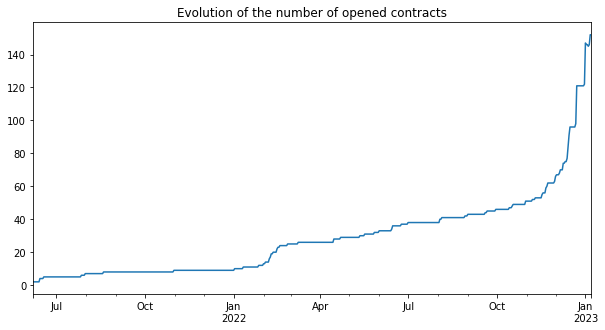

In [8]:
num_contracts.plot(figsize=(10, 5), legend = False, title = 'Evolution of the number of opened contracts')

### Relation between Smart Meter contracts and solar panels contracts

**Assumption:**:
* If p1_actual_kwh is negative, the customer has a solar panel installed. The solar panels may have be installed with Zonneplan or not. When installed with Zonneplan, a pv_actual_kwh measure is available.

**Observations:**
* **40%** of smart meter contracts have solar panels **installed with Zonneplan**
* about **20%** of smart meter cotnracts have solar panel **not installed with Zonneplan**

In [9]:
# Set of contract_id having a smart meters
smart_meter_contract = set(values_actual[~values_actual['p1_actual_kwh'].isnull()]['contract_id'])

# Set of contract_id having solar panels with Zonneplan (based of pv_actual_kwh)
pv_w_zp_contract = set(values_actual[~values_actual['pv_actual_kwh'].isnull()]['contract_id'])

# (Inferred) Set of contract_id having solar panel not with Zonneplan
# To do so, we assume that contract_id with p1_actual_kwh < 0 have solar panels
customer_w_pv = set(values_actual[values_actual['p1_actual_kwh'] < 0]['contract_id'])
pv_wo_zp_contract = customer_w_pv - pv_w_zp_contract

In [10]:
# proportion of pv_contracts in the smart_meter_contracts
#print("proportion of pv_contracts: {:.2f}".format(len(pv_contract) / len(smart_meter_contract)))
print("Proportion of pv contracts with Zonneplan: {:.2f}".format(len(pv_w_zp_contract) / len(smart_meter_contract)))
print("(Inferred) proportion of pv contracts without Zonneplan: {:.2f}".format(len(pv_wo_zp_contract) / len(smart_meter_contract)))

Proportion of pv contracts with Zonneplan: 0.40
(Inferred) proportion of pv contracts without Zonneplan: 0.20


## Smart meter consumption

The pv_actual_kwh is measured at the inverter of the solar panels for customers that have both solar panels that we installed and have an energy contract with us. It’s separate from the smart meter measurement. In the p1_actual_kwh (from the smarter meter) the consumption from the household minus the pv_actual_kwh is measured. So **consumption of household = pv_actual + p1_actual_kwh** <br>

**Obervations:**
1. About 1.6% values from the smart meters are missing. Based on the limited number of data, it is preferable to remove them
2. There are 3 outliers with a |p1_actual_kwh| > 5*10e3. They seem to really be anomalies and should be removed for forecasting
3. Like we have seen previously there are many new contracts during the month of December. Thus each house are not equally represented in the data. Consequently, rather than looking at the average (for instance) consumption at a given time, we should average the consumption of all households (contracts).
4. There are households with solar panels installed by Zonneplan and with additional source of power. Indeed, they have **negative values of p1_actual_kwh + pv_actual_kwh**

In [11]:
# Create a DataFrame Consumption with acutal data
consumption = values_actual[['contract_id', 'timestamp', 'p1_actual_kwh', 'pv_actual_kwh']].copy()

In [12]:
# Check missing values
consumption.isnull().mean()

contract_id      0.000000
timestamp        0.000000
p1_actual_kwh    0.016734
pv_actual_kwh    0.752893
dtype: float64

In [13]:
# Replace NaN of pv_actual_kwh by 0
consumption['pv_actual_kwh'] = consumption['pv_actual_kwh'].replace(np.nan, 0)

# Create a feature 'consumption' as the sum of the consumption and solar generated power
consumption['consumption'] = consumption['p1_actual_kwh'] + consumption['pv_actual_kwh']

<AxesSubplot:>

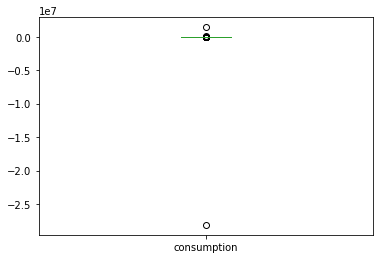

In [14]:
consumption.consumption.plot.box()

In [15]:
# there are extreme values compared to others, are they outliers?
# look at extreme ones
threshold = 5*10e3
outliers = consumption[(consumption.consumption < -threshold) | (consumption.consumption > threshold)]
outliers

,contract_id,timestamp,p1_actual_kwh,pv_actual_kwh,consumption
775,105587,2022-12-09 01:45:00,1414444.0,0.000000,1.414444e+06
2160,105587,2022-12-23 12:00:00,99999.0,13.083333,1.000121e+05
7293,128443,2022-12-13 09:15:00,-28121994.0,34.083333,-2.812196e+07


In [16]:
# remove outliers
consumption_cleaned = consumption[(consumption.consumption > -threshold) & \
                                  (consumption.consumption < threshold)].copy()

### Number of data per household

In [17]:
# list of the number of data per customer
data_per_contract = [consumption.contract_id.value_counts()[i] for i in set(consumption.contract_id)]
print("The contract with the maximum number of data has {} data points.".format(max(data_per_contract)))
print("The contract with the minimum number of data has {} data points.".format(min(data_per_contract)))

The contract with the maximum number of data has 4416 data points.
The contract with the minimum number of data has 4 data points.


We can see that houses are inequally represented in the dataset.

### Relation between consumption and time of the day
We are now interested in looking at the hourly average consumption on a household. To do so, we need to remove the generated solar power from our equation. We estimate this by removing from the dataset the household which have solar panels not installed with Zonneplan since we don't know the exact solar power generated for these households (estimated earlier). <br>

**Observations:**
* The consumption is highly dependant on the time of the day

In [18]:
# Remove (estimated) customers with solar panels not installed with Zonneplan
consumption_zp = consumption_cleaned[~consumption_cleaned.contract_id.isin(pv_wo_zp_contract)]

In [19]:
consumption_zp[consumption_zp.consumption < 0].head()

,contract_id,timestamp,p1_actual_kwh,pv_actual_kwh,consumption
809,105587,2022-12-09 10:15:00,-80.0,73.833333,-6.166667
1111,105587,2022-12-12 13:45:00,-89.0,88.333333,-0.666667
1291,105587,2022-12-14 10:45:00,-578.0,485.750000,-92.250000
1768,105587,2022-12-19 10:00:00,52.0,-100.000000,-48.000000
1972,105587,2022-12-21 13:00:00,-122.0,108.083333,-13.916667


The customer '105587' feed in 578 kwh a certain time but produced only 485 kwh. It means that this customer has an source of energy.

In [20]:
# Group the data by contract_id and date, and calculate the average power per contract
averaged = consumption_zp.groupby(['contract_id', consumption_zp['timestamp'].dt.hour]) \
['consumption'].mean()

# Convert the grouped data back to a dataframe
averaged = averaged.reset_index()

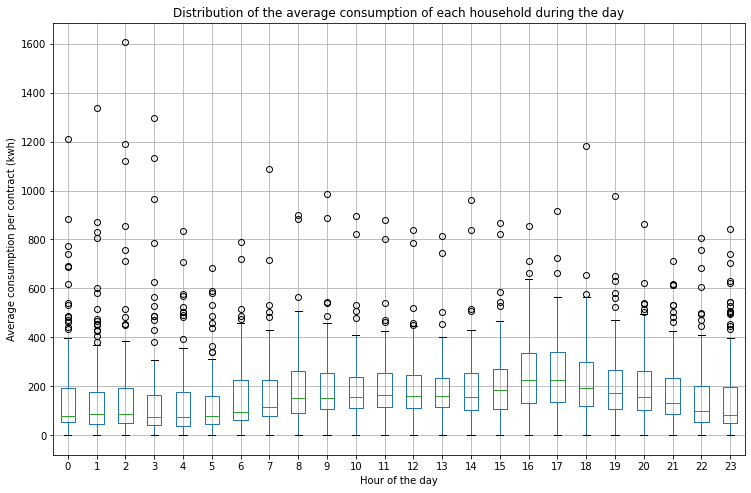

In [21]:
ax = averaged.boxplot(column='consumption', by='timestamp', figsize=(12,8))
title_boxplot = 'Distribution of the average consumption of each household during the day'
plt.title( title_boxplot )
plt.suptitle('')
ax.set_xlabel("Hour of the day")
ax.set_ylabel("Average consumption per contract (kwh)")
plt.show()

We notice negative values. This confirms that some customer have solar panels which are not from Zonneplan.

(0.0, 260.0)

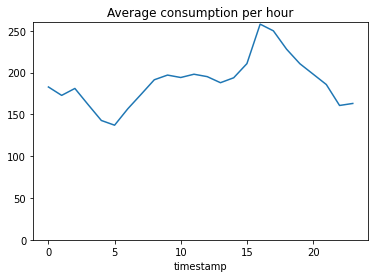

In [22]:
averaged.groupby('timestamp')['consumption'].mean().plot(title = 'Average consumption per hour')
plt.ylim((0,260))

Logically we notice that the average consumption  varies largely during the day. There is a lower consumption around 4am and and 5am, and a high peak around 4pm and 5pm. The higher consumption might be partly explained by the fact that people are coming back home (and maybe need to warm up the house - the data is from December).

### Relation between consumption and day of the week
**Observations:**
* The consumption does not seem very correlated to the day of the week. Note that we only have 3 weeks of data so this statement should be reconsidered when having data on a longer period of time.

In [23]:
# Group the data by contract_id and date, and calculate the average power per contract
averaged = consumption_zp.groupby(['contract_id', consumption_zp['timestamp'].dt.weekday]) \
['consumption'].mean()

# Convert the grouped data back to a dataframe
averaged = averaged.reset_index()

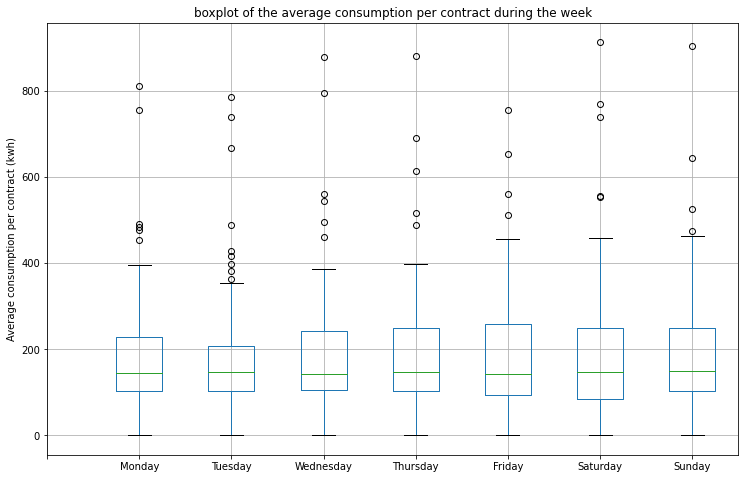

In [24]:
ax = averaged.boxplot(column='consumption', by='timestamp', figsize=(12,8))
title_boxplot = 'boxplot of the average consumption per contract during the week'
plt.title(title_boxplot )
plt.suptitle('')
ax.set_xlabel('')
ax.set_ylabel("Average consumption per contract (kwh)")
plt.xticks(range(8), labels= ['', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.show()

### Relation between consumption and energy price
**Observations:**
* The fact that customers consume less when price is higher is not obvisous here. Further investigation is needed to analysis the relationship between price and consumption. For intance, a further analysis may highlight 2 "extreme" type of customer: those adjusting their consumption as much as possible with price fluctuation and those you are not careful at all about it. One way to analysis could be by analysis the correlation, per customer, between the consumption and the price.

In [25]:
prices.head()

,timestamp,price_epex
0,2022-12-08 00:00:00,0.284
1,2022-12-08 00:15:00,0.284
2,2022-12-08 00:30:00,0.284
3,2022-12-08 00:45:00,0.284
4,2022-12-08 01:00:00,0.273


In [26]:
prices.timestamp.min()

Timestamp('2022-12-08 00:00:00')

In [27]:
prices.timestamp.max()

Timestamp('2023-01-08 23:45:00')

In [28]:
prices.isnull().mean()

timestamp     0.0
price_epex    0.0
dtype: float64

(19335.0, 19342.0)

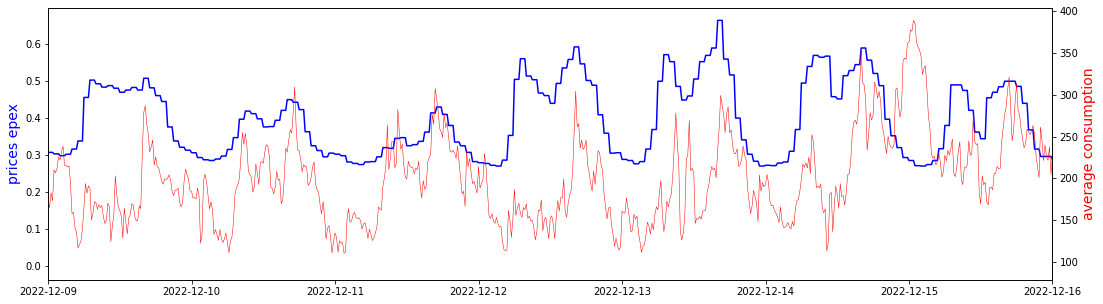

In [29]:
# Create plot for price
fig,ax = plt.subplots(figsize=(18,5))
ax.plot(prices.timestamp, prices.price_epex, color = 'blue')
ax.set_ylabel("prices epex",fontsize=14, color = 'blue')

# Add plot for consumption (only with Zonneplan)
ax2=ax.twinx()
cons_wo_pv = values_actual[~values_actual.contract_id.isin(customer_w_pv)]
averaged = consumption_zp.groupby([consumption_zp['timestamp']])['consumption'].mean()
ax2.plot(averaged.index, averaged.values, color = 'red', linewidth=0.5)
ax2.set_ylabel("average consumption",fontsize=14, color = 'red')

# Set limit to x-axis
min_date = averaged.index.min()
max_date = min_date + timedelta(days=7)
#max_date = averaged.index.max()
plt.xlim((min_date, max_date))

The fact that customers consume less when price is higher is not obvisous here. Further investigation is needed to analysis the relationship between price and consumption.

In [30]:
# We want to look at the relatin between the energy consumption and  the energy price.
# To do so, we need to concatenate the consumption data with the price data based on the timestamp

Text(0.5, 0, 'Hour of the day')

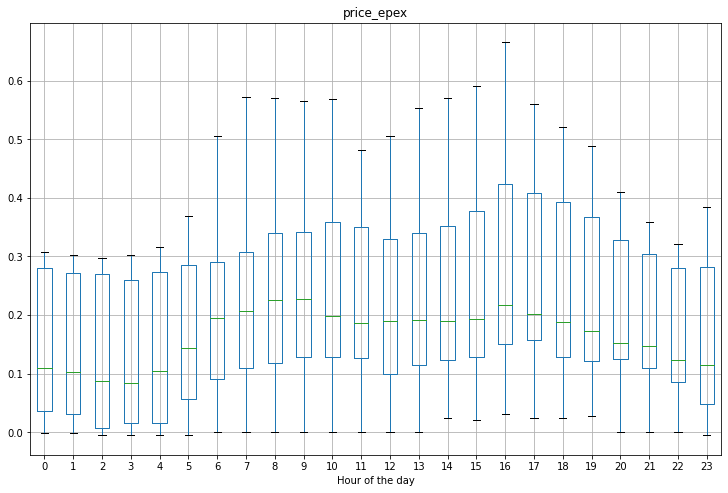

In [31]:
ax = prices.boxplot(column='price_epex', by=[prices['timestamp'].dt.hour], figsize=(12,8))
plt.suptitle('')
ax.set_xlabel("Hour of the day")

In [32]:
# Average consumption at a given time
averaged_consumption = consumption_cleaned[['timestamp', 'consumption']].groupby(consumption_cleaned['timestamp']) \
['consumption'].mean()

In [33]:
# Dataframe merging the consumption and prices
merged = pd.concat([prices.set_index('timestamp'), averaged_consumption], axis=1)
merged.dropna(inplace=True)

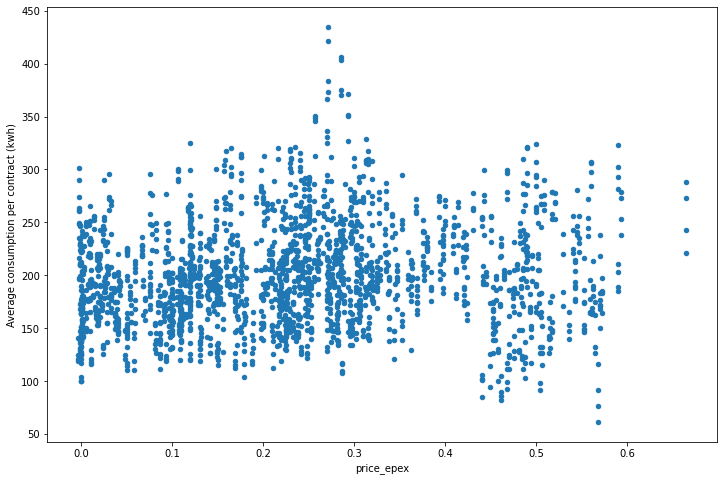

In [34]:
# Scatter plot to visualize the relation between price and consumption
ax = merged.plot.scatter(x='price_epex', y='consumption', figsize=(12,8))
ax.set_ylabel("Average consumption per contract (kwh)")
plt.show()

TO DO:
* we know that some customer have solar panel. So we could look at the consumption of househol without solar panel. But this is tricky because we don't know all houses without soalr panels. mayb the power generated my solar panel could be substracted from p1... What is the proportion of customer with solar panel not from Zonneplan?

# Solar Power Generation

**Obervations:**
* Limited available data: only 22 days of data available (thus a bit more than 3 weeks -> 3*7 = 21 data point at best per quarter of hour per household). Rather than looking forecasting the power generation of each household individually we can look at the average.
* The data available is during the month of Decembre. There was a large **number of new customers** during this period. This needs to be considered

In [35]:
pv_power = values_actual[['contract_id', 'timestamp', 'pv_actual_kwh', 'pv_forecast_kwh']]

In [36]:
pv_power.head()

,contract_id,timestamp,pv_actual_kwh,pv_forecast_kwh
768,105587,2022-12-09 00:00:00,NaN,0.0
769,105587,2022-12-09 00:15:00,NaN,0.0
770,105587,2022-12-09 00:30:00,NaN,0.0
771,105587,2022-12-09 00:45:00,NaN,0.0
772,105587,2022-12-09 01:00:00,NaN,0.0


In [37]:
pv_power.isnull().mean()

contract_id        0.000000
timestamp          0.000000
pv_actual_kwh      0.752893
pv_forecast_kwh    0.149115
dtype: float64

In [38]:
pv_power.describe()

,contract_id,pv_actual_kwh,pv_forecast_kwh
count,229836.000000,56794.000000,195564.000000
mean,106506.703145,50.838662,14.856617
std,35335.963116,107.631559,54.518703
min,35297.000000,-1290.000000,0.000000
25%,86368.000000,0.000000,0.000000
50%,122917.000000,13.083333,0.000000
75%,138372.000000,48.416667,0.000000
max,143929.000000,1753.750000,1358.000000


In [39]:
# Negative values are outliers, let's remove them
pv_power = pv_power[pv_power.pv_actual_kwh > 0].copy()

In [40]:
print('time delta tof the data:')
pv_power.timestamp.max() - pv_power.timestamp.min()

time delta tof the data:


Timedelta('22 days 08:30:00')

In [41]:
pv_power['hour'] = [time.hour for time in pv_power.timestamp.tolist()]

<AxesSubplot:title={'center':'pv_actual_kwh'}, xlabel='hour'>

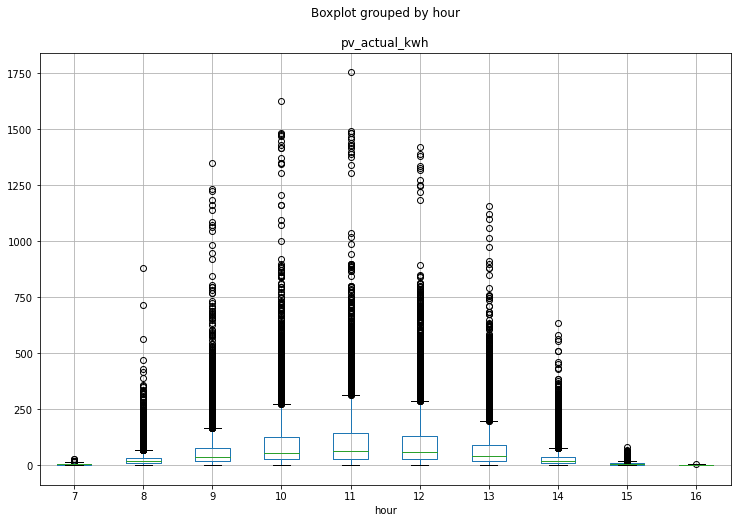

In [42]:
pv_power.boxplot(column='pv_actual_kwh', by='hour', figsize=(12,8))

## Look at the current difference between the forecast and actual solar power data

In [43]:
# Keep data where both pv_actual_kwh and pv_forecast_kwh are not null
diff_pv_power = pv_power.loc[(~pv_power.pv_actual_kwh.isnull()) & \
                                      (~pv_power.pv_forecast_kwh.isnull())].copy()

<AxesSubplot:ylabel='Density'>

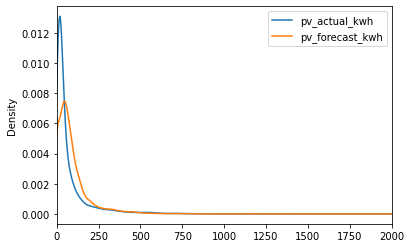

In [44]:
diff_pv_power[['pv_actual_kwh', 'pv_forecast_kwh']].plot(kind='density', xlim = {0, 2000})

In [45]:
diff_pv_power['diff'] = (diff_pv_power.pv_actual_kwh - diff_pv_power.pv_forecast_kwh)

In [46]:
# convert per hour and check the fluctuation
diff_pv_power['hour'] = [time.hour for time in diff_pv_power.timestamp.tolist()]

<AxesSubplot:title={'center':'diff'}, xlabel='hour'>

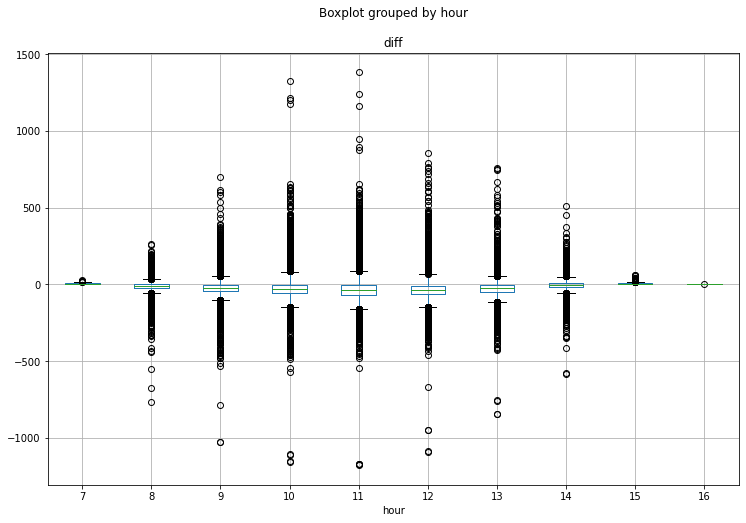

In [47]:
diff_pv_power.boxplot(column='diff', by='hour', figsize=(12,8))

# Forecast
**Methods:**
* Naive methods: Average previous consumption off all households together by considering feature like time
* Conidering additional pv input: Predict the solar production for household with solar without Zonneplan
* fine-tune per customer: create model per customer

# Challenges
* Combination of households with solar panels installed by Zonneplan and not with Zonneplan: some household have energy sources we are not aware of. They can be identified by having negative values of consumption.

# Possible next steps¶
* Look at possible clusters: based on infrastructure (with or withut solar panels), consumption behavior pattern (households consuming more at certain time than other householads, and less at certain time), cluster of location
* Consideration of additional solar power data: size and tild of the solar panels
* Classification of customer with/without solar panels: using other data sources? Solar panels detection from satellites images?
* Look at other data set like Kaggle

To improve this prediction in the coming months, we will continue to collect and analyze historical data and update our models accordingly. We will also explore other forecasting methods, such as the Prophet model developed by Facebook, and machine learning techniques, such as random forests and neural networks.

One aspect that could have been better is the data cleaning and preprocessing. There were some missing values and inconsistencies in the data that needed to be addressed before we could create an accurate forecast. In the future, we will need to ensure that we have clean and consistent data before proceeding with the forecasting process.

Another area for improvement is the incorporation of external factors that could impact consumption, such as holidays, events, and changes in government policies. By including these factors in our forecasting models, we can create more accurate and robust predictions for our energy portfolio.

In [48]:
def remove_outliers_zscore(data, threshold=3):
    """
    Removes outliers from a time series using the Z-score method.
    
    Parameters:
    data (np.ndarray): The time series data.
    threshold (float): The Z-score threshold for identifying outliers. Defaults to 3.
    
    Returns:
    np.ndarray: The time series data with outliers removed.
    """
    z_scores = np.abs((data - np.mean(data)) / np.std(data))
    mask = z_scores < threshold
    return data[mask]